<a href="https://colab.research.google.com/github/giulicrenna/data_science/blob/main/ProyectoDS_ParteI_%2BCrenna_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install chart_studio
! pip install bqplot
! pip install pingouin

In [139]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.formula.api as sm
import pingouin
from scipy.stats import ttest_ind, kstest
from sklearn.metrics import r2_score
from google.colab import drive

drive.mount('/content/gdrive')
sns.set_theme(style="darkgrid")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
covidDataset = pd.read_excel("/content/gdrive/MyDrive/Colab Notebooks/Visualizacion-Crenna.xlsx")

# Pregunta 1
Me interesaría saber cual es la cantidad de días entre el diágnostico de covid y el fallecimiento de la persona (Para los casos donde la persona efectivamente haya fallecido por covid)

In [84]:
""" 
Cargo el dataset en una variable covidDatasetRestore ya que si hago un cambio al covidDataset lo puedo recuperar con el restore
Esto me sirve ya que el dataset al ser muy grande tarda mucho en ser cargado.
"""
covidDatasetRestore = covidDataset[covidDataset["edad"] < 107]
covidDataset = covidDatasetRestore
"""
Convierto las columnas de fechas en un formate dateTime de pandas.
"""
covidDataset.fecha_diagnostico = pd.to_datetime(covidDataset.fecha_diagnostico)
covidDataset.fecha_fallecimiento = pd.to_datetime(covidDataset.fecha_fallecimiento)
covidDataset["edad"] = covidDataset.edad.astype(int)
"""
Selecciono los casos dónde las personas hayan fallecido.
"""
covidFallecidos = covidDataset[covidDataset["fallecido"] == 'SI']

In [116]:
"""
Esta función nos calcula el promedio de días entre el diagnóstico y la fecha de fallecimiento por edad
"""
def diferencia_fechas_por_edad(edad : int = 0) -> float:
  tempDataset = covidFallecidos[covidFallecidos["edad"] == edad]
  diferenciaSeries = tempDataset.fecha_fallecimiento - tempDataset.fecha_diagnostico
  return abs(float(round(diferenciaSeries.dt.days.mean(), 1)))

def diferencia_fechas_por_edad_no_prom(fecha_inicio, fecha_final) -> float:
  diferencia = pd.to_datetime(fecha_final) - pd.to_datetime(fecha_inicio)
  return abs(float(round(diferencia.days, 1)))

In [72]:
"""
Creo un nuevo data frame donde almacenaré cada edad con el promedio de días.
"""
promDiasDataframe = pd.DataFrame()
edad_ = []
prom_dias = []

for edad in range(1, 115):
  try:
    prom_dias.append(diferencia_fechas_por_edad(edad))
    edad_.append(edad)
  except:
    pass

promDiasDataframe["edad"] = edad_
promDiasDataframe["prom_dias"] = prom_dias

promDiasDataframe = promDiasDataframe.dropna()

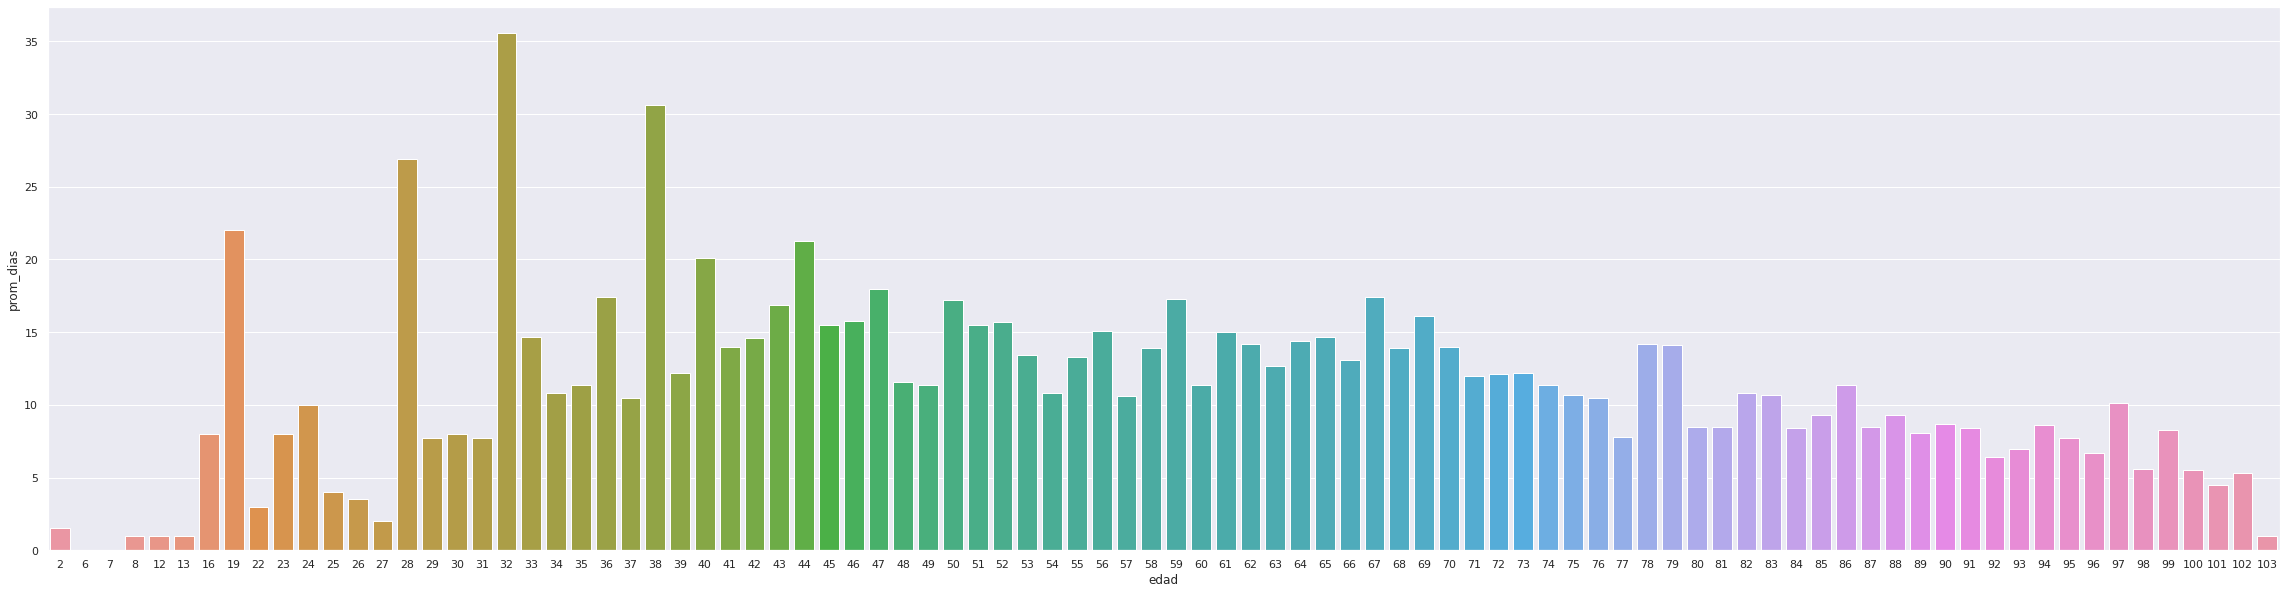

In [83]:
"""
Con este gráfico podemos visualizar más facilmente cuales son las edades que mas han días han durado con covid
antes de fallecer.
"""
f, ax = plt.subplots(figsize=(40, 10))
sns.barplot(data=promDiasDataframe, y = promDiasDataframe.prom_dias, x = promDiasDataframe.edad);

# Pregunta 2
Ahora me interesaría realizar un scatter plot para poder ver si existe alguna posibilidad de realizar una regresión lineal.

In [124]:
"""
genero el dataset con los el time delta de cada fila.
"""
scatterDataSet = covidFallecidos[["edad", "fecha_fallecimiento", "fecha_diagnostico"]]
singleDay = []
for index, row in scatterDataSet.iterrows():
  try:
    day = diferencia_fechas_por_edad_no_prom(row[1], row[2])
    singleDay.append(day)
  except Exception as e:
    pass

scatterDataSet["days"] = singleDay;
scatterDataSet = scatterDataSet.dropna()

<ipython-input-124-5ae6b356d61b>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scatterDataSet["days"] = singleDay;


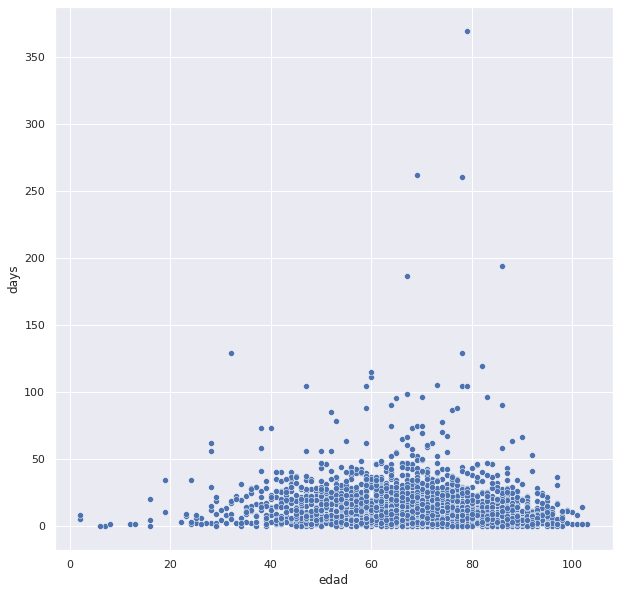

In [127]:
f, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(data=scatterDataSet, x = scatterDataSet.edad, y = scatterDataSet.days);

In [130]:
"""
Ahora analizo las columnas para hacer los tests.
"""
modelo1 = "edad~days"
md1 = sm.ols(formula = modelo1, data = scatterDataSet).fit()
print(md1.summary())

                            OLS Regression Results                            
Dep. Variable:                   edad   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     42.92
Date:                Tue, 31 Jan 2023   Prob (F-statistic):           6.62e-11
Time:                        01:20:18   Log-Likelihood:                -12980.
No. Observations:                3184   AIC:                         2.596e+04
Df Residuals:                    3182   BIC:                         2.598e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     70.5619      0.323    218.674      0.0

In [145]:
"""
Al ser el p-val menor a 0.05, es un valor válido.
Al ser el R2 negativo nos indica una alta variabilidad de los datos,
no podremos realizar un modelo de regresión lineal para los mismos.
"""
pval = kstest(scatterDataSet.days, scatterDataSet.edad).pvalue
r2 = r2_score(scatterDataSet.days, scatterDataSet.edad)

print("El pval del modelo es: {}".format(pval))
print("El puntaje R2 es: {}".format(r2))

El pval del modelo es: 0.0
El puntaje R2 es: -12.452223235126933
